# Intuit Quickbooks Upgrade
* Name: Shiyi Hua, Wan Qiu, Siwei Xie, Ziyuan Yan
* GitLab id: rsm-s8hua

## Setup

Please complete this python notebook with your group by answering the questions in `intuit.pdf` on Canvas (week6/). Create a Notebook/HTML file with all your results and comments and push both the Rmarkdown and HTML file to GitLab when your team is done. All results MUST be reproducible (i.e., the TA and I must be able to recreate the HTML from the Jupyter Notebook file without changes or errors). This means that you should NOT use any python-packages that are not part of the rsm-msba-spark docker container.

This is the first group assignment for MGTA 455 and you will be using git and GitLab. If two people edit the same file at the same time you could get what is called a "merge conflict". git will not decide for you who's change to accept so the team-lead will have to determine which edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitLab. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. 

Group work-flow tips as discussed during ICT in Summer II are shown below:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file 
* If you are going to work simultaneously, do it in different notebooks, e.g., 
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook

A graphical depiction of the group work-flow is shown below:

![](../images/git-group-workflow.png)

Tutorial videos about using Git, GitLab, and GitGadget for group assignments:

* Setup the MSBA server to use Git and GitLab: https://youtu.be/oUrI7G3NHDg
* Dealing with Merge Conflicts: https://youtu.be/elq5UUG0RbE
* Group assignment practice: https://youtu.be/uwqUHl3z37o

Additional resources on git are linked below:

* http://happygitwithr.com
* http://r-pkgs.had.co.nz/git.html
* http://stackoverflow.com/questions/tagged/git or just a google search
* https://try.github.io
* https://www.manning.com/books/git-in-practice
* https://github.com/GitInPractice/GitInPractice#readme

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyrsm import gains, gains_plot, lift, lift_plot, confusion, profit_max, ROME_max

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("../data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k["sex_male"] = (intuit75k["sex"] == "Male").astype(int)
intuit75k["sex_female"] = (intuit75k["sex"] == "Female").astype(int)
intuit75k["zip_bins_category"] = (intuit75k["zip_bins"]).astype('category')
intuit75k["bizflag_category"] = (intuit75k["bizflag"]).astype('category')
intuit75k["version1_category"] = (intuit75k["version1"]).astype('category')
intuit75k["owntaxprod_category"] = (intuit75k["owntaxprod"]).astype('category')
intuit75k["upgraded_category"] = (intuit75k["upgraded"]).astype('category')
intuit75k["dollars_ln"] = np.log(intuit75k["dollars"])
intuit75k["sincepurch_ln"] = np.log(intuit75k["sincepurch"])
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,...,res1_yes,sex_male,sex_female,zip_bins_category,bizflag_category,version1_category,owntaxprod_category,upgraded_category,dollars_ln,sincepurch_ln
0,1,94553,18,Male,0,2,109.5,5,12,0,...,0,1,0,18,0,0,0,0,4.695925,2.484907
1,2,53190,10,Unknown,0,1,69.5,4,3,0,...,0,0,0,10,0,0,0,0,4.241327,1.098612
2,3,37091,8,Male,0,4,93.0,14,29,0,...,0,1,0,8,0,0,0,1,4.532599,3.367296
3,4,02125,1,Male,0,1,22.0,17,1,0,...,0,1,0,1,0,0,0,0,3.091042,0.000000
4,5,60201,11,Male,0,1,24.5,2,3,0,...,0,1,0,11,0,0,0,0,3.198673,1.098612


In [3]:
rvar = "res1_yes"
evar = [
    "zip_bins_category",
    "sex_male",
    "sex_female",
    "bizflag_category",
    "numords",
    "dollars_ln",
    "last",
    "sincepurch_ln",
    "version1_category",
    "owntaxprod_category",
    "upgraded_category"
]
idvar = "id"
lev = "Yes"

In [4]:
train = intuit75k[intuit75k["training"] == 1]
test = intuit75k[intuit75k["training"] == 0]

In [5]:
eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

In [6]:
X_train = train[evar]
y_train = train[rvar]
X_test = test[evar]
y_test = test[rvar]

In [7]:
# scaling the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply transformation to training data
Xs_train = scaler.transform(X_train)

# apply same transformation to test data
Xs_test = scaler.transform(X_test)

# combining so we can predict for the full dataset as well
Xs = np.concatenate((Xs_train, Xs_test), axis=0)

In [8]:
## Neural Network from SKLEARN
clf = MLPClassifier(
    solver="adam",
    learning_rate_init=0.01,
    alpha=0.01,
    hidden_layer_sizes=(2, 2),
    random_state=1234,
    max_iter=1000,
)

clf.fit(Xs_train, y_train)

nn_proba = clf.predict_proba(Xs)
eval_dat["y_nn"] = nn_proba[:, 1]
eval_dat

,id,res1_yes,training,y_nn
0,1,0,1,0.025226
3,4,0,1,0.022299
5,6,0,1,0.070005
7,8,0,1,0.040732
9,10,0,1,0.045063
...,...,...,...,...
74981,74982,0,0,0.018878
74982,74983,0,0,0.011804
74987,74988,0,0,0.084310
74993,74994,1,0,0.223244


In [9]:
# CV for NN
nr_hnodes = range(4, 6)
hls = (
    list(zip(nr_hnodes))
    + list(zip(nr_hnodes, nr_hnodes))
    + list(zip(nr_hnodes, nr_hnodes, nr_hnodes))
)
hls

[(4,), (5,), (4, 4), (5, 5), (4, 4, 4), (5, 5, 5)]

In [10]:
param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05]}
scoring = {"AUC": "roc_auc"}

In [11]:
clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)

In [12]:
clf_cv.fit(Xs_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   56.3s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  1.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.01,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(2, 2),
                                     learning_rate='constant',
                                     learning_rate_init=0.01, max_fun=15000,
                                     max_iter=1000, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1234, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=4,
             param_grid={'alp

In [13]:
clf_cv.best_params_
clf_cv.best_score_
results = pd.DataFrame(clf_cv.cv_results_)
results = results.sort_values(by=["rank_test_AUC"])
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_hidden_layer_sizes,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
4,4.522922,0.217659,0.004599,0.000104,0.001,"(4, 4, 4)","{'alpha': 0.001, 'hidden_layer_sizes': (4, 4, 4)}",0.740795,0.754164,0.763011,0.747699,0.763121,0.753758,0.008697,1
10,4.772729,0.690814,0.004905,0.000379,0.01,"(4, 4, 4)","{'alpha': 0.01, 'hidden_layer_sizes': (4, 4, 4)}",0.708259,0.758891,0.762006,0.751679,0.768099,0.749787,0.021428,2
16,4.435801,0.538011,0.004744,0.000232,0.05,"(4, 4, 4)","{'alpha': 0.05, 'hidden_layer_sizes': (4, 4, 4)}",0.718827,0.755131,0.761833,0.746126,0.759718,0.748327,0.015707,3
15,5.194851,1.801255,0.004622,0.000189,0.05,"(5, 5)","{'alpha': 0.05, 'hidden_layer_sizes': (5, 5)}",0.735363,0.754576,0.761001,0.708063,0.753592,0.742519,0.019225,4
3,4.849643,1.641719,0.004802,0.000193,0.001,"(5, 5)","{'alpha': 0.001, 'hidden_layer_sizes': (5, 5)}",0.730118,0.754298,0.750836,0.706055,0.754423,0.739146,0.018847,5
11,5.764619,2.132894,0.005106,0.000556,0.01,"(5, 5, 5)","{'alpha': 0.01, 'hidden_layer_sizes': (5, 5, 5)}",0.724307,0.756711,0.718401,0.734624,0.759171,0.738643,0.016609,6
2,3.978738,1.024860,0.004692,0.000247,0.001,"(4, 4)","{'alpha': 0.001, 'hidden_layer_sizes': (4, 4)}",0.722902,0.707534,0.766765,0.732179,0.748202,0.735516,0.020448,7
9,4.610104,2.111802,0.004784,0.000377,0.01,"(5, 5)","{'alpha': 0.01, 'hidden_layer_sizes': (5, 5)}",0.699733,0.749298,0.758306,0.739314,0.721241,0.733578,0.020924,8
8,3.738391,0.586919,0.004372,0.000079,0.01,"(4, 4)","{'alpha': 0.01, 'hidden_layer_sizes': (4, 4)}",0.719890,0.708739,0.748131,0.734637,0.749644,0.732208,0.015912,9
5,5.355172,1.340654,0.005129,0.000695,0.001,"(5, 5, 5)","{'alpha': 0.001, 'hidden_layer_sizes': (5, 5, 5)}",0.728375,0.749956,0.717983,0.725637,0.729758,0.730342,0.010619,10


In [14]:
nn_proba = clf_cv.best_estimator_.predict_proba(Xs)
eval_dat["y_nn_cv"] = nn_proba[:, 1]
eval_dat

,id,res1_yes,training,y_nn,y_nn_cv
0,1,0,1,0.025226,0.028980
3,4,0,1,0.022299,0.143288
5,6,0,1,0.070005,0.058165
7,8,0,1,0.040732,0.052023
9,10,0,1,0.045063,0.037777
...,...,...,...,...,...
74981,74982,0,0,0.018878,0.024338
74982,74983,0,0,0.011804,0.012022
74987,74988,0,0,0.084310,0.167087
74993,74994,1,0,0.223244,0.117842


In [15]:
pred = clf_cv.predict_proba(Xs_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train.values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7572017295449094

In [16]:
# prediction on test set
pred = clf_cv.predict_proba(Xs_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, pred[:, 1])
auc_rf = metrics.auc(fpr, tpr)
auc_rf

0.7527032348058385

In [17]:
profit_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn", cost=1.41, margin=60)

36068.130000000005

In [18]:
profit_max(
    eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", cost=1.41, margin=60
)

37938.72

In [19]:
ROME_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn", cost=1.41, margin=60)

1.8005373437427463

In [20]:
ROME_max(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", cost=1.41, margin=60)

1.7928367282130384

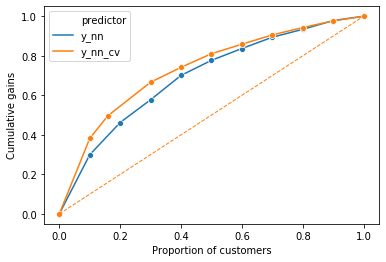

In [21]:
gains(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn", qnt=10)
gains(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", qnt=10)
gains_plot(
    eval_dat.query("training == 0"),
    "res1_yes",
    1,
    ["y_nn", "y_nn_cv"],
    qnt=10,
)

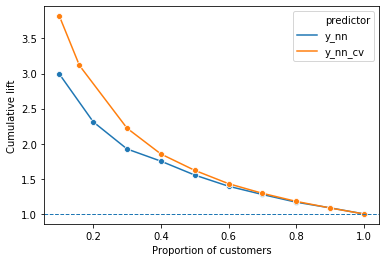

In [22]:
lift(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn", qnt=10)
lift(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", qnt=10)
lift_plot(
    eval_dat.query("training == 0"),
    "res1_yes",
    1,
    ["y_nn", "y_nn_cv"],
    qnt=10,
)

In [23]:
confusion(eval_dat.query("training == 0"), "res1_yes", 1, "y_nn", cost=1.41, margin=60)

(935, 13272, 8125, 168, 0.6314222222222222)

In [24]:
confusion(
    eval_dat.query("training == 0"), "res1_yes", 1, "y_nn_cv", cost=1.41, margin=60
)

(985, 14023, 7374, 118, 0.6670222222222222)